<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/PSF_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installs**

In [1]:
!pip install hcipy --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.4/241.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 18.3 MB/s eta 0:00:00


In [2]:
!pip install --force-reinstall jsonschema==3.2.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
asdf 2.15.0 requires jsonschema<4.18,>=4.0.1, but you have jsonschema 3.2.0 which is incompatible.


In [3]:
!pip install photutils --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install poppy --quiet

Run above cells and restart runtime. Continue to run the cells below.

# **Imports**

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb


import yaml
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from scipy.signal import fftconvolve
from astropy.table import Table

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture

from scipy.stats import norm

import os
from time import perf_counter
import json
import requests


# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **GitHub**

In [7]:
!git clone https://github.com/Jack3690/INSIST/ --quiet

In [8]:
cd /content/INSIST/data

/content/INSIST/data


# **Simple PSF Generator**

Enter FWHM of source in arcsecond : 
Enter AB magnitude of the source  : 


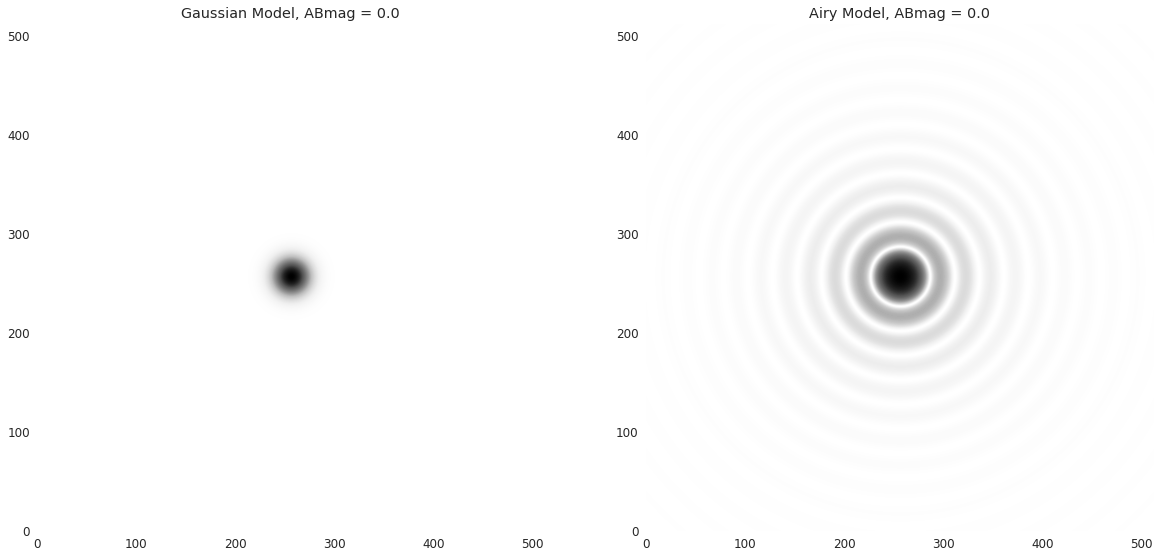

In [ ]:
fwhm_in = float(input("Enter FWHM of source in arcsecond : ") or "0.3")
ABmag   = float(input("Enter AB magnitude of the source  : ") or "0")

# Flux to AB magnitude
flux = 3631*pow(10,-ABmag/2.5)

pixel_scale = 0.01 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma

# Amplitude of a gaussian for given flux and standard deviation.
amplitude_g = flux/(sigma_psf**2*2*np.pi)

amplitude_a = (flux)/(0.8569446798286412*fwhm**2)

# Number of pixels.
n_pix = 512
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
model_gauss = models.Gaussian2D(amplitude_g, len(x)//2, len(x)//2, sigma_psf, sigma_psf)

# Modelling a Airy Disk of same amplitude.
model_airy = models.AiryDisk2D(amplitude_a, len(x)//2, len(x)//2, fwhm)

image_g = model_gauss(x,y)

image_a = model_airy(x,y)

# Plot
fix, ax = plt.subplots(1,2,figsize=(20,10))

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(np.log10(1+image_g/image_g.max()),origin='lower',cmap='Greys',vmin=1e-11)
ax[0].set_title(f'Gaussian Model, ABmag = {ABmag}')

ax[1].imshow(image_a,origin='lower',cmap='Greys',norm=norm)
ax[1].set_title(f'Airy Model, ABmag = {ABmag}');

In [ ]:
flux

3631.0

In [ ]:
image_g.sum(), flux, image_a.sum()

(3630.9999999999995, 3631.0, 3562.8006605994397)

Airy Disk not modelled properly yet

# **PSF Simulation using HCIPy**

In [ ]:
from hcipy import *

## **Circular Aperture (INSIST-Off Axis)**

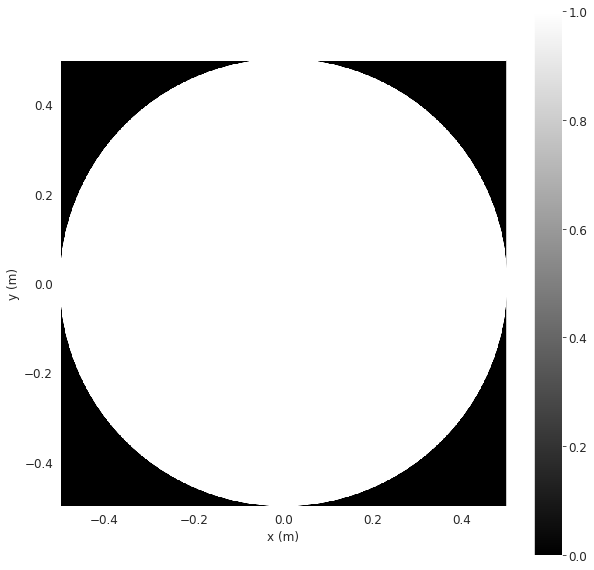

In [ ]:
pupil_diameter           = 1.0 # m

effective_focal_length   = 20 # m

pupil_grid               = make_pupil_grid(1024, diameter = pupil_diameter)

aperture                 = circular_aperture(pupil_diameter)

telescope_pupil_off_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_off_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis,wavelength)
  focal_grid = make_focal_grid(q = 6, num_airy= 4*42.68,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
(focal_grid.separated_coords[0].max() - focal_grid.separated_coords[0].min())/(focal_total.shape[0]*1e-6)

0.9995117187500001

In [ ]:
off_axis = np.array(focal_total/10)
off_axis = off_axis/off_axis.sum()
off_axis.sum(), off_axis.shape

(0.9999999999999994, (2048, 2048))

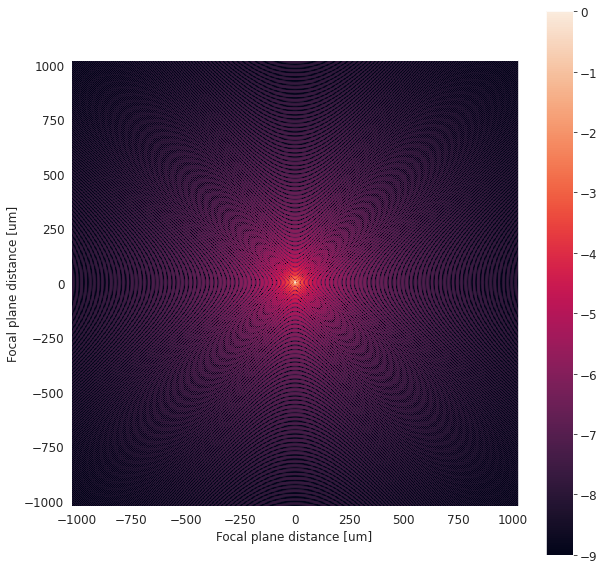

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-9, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

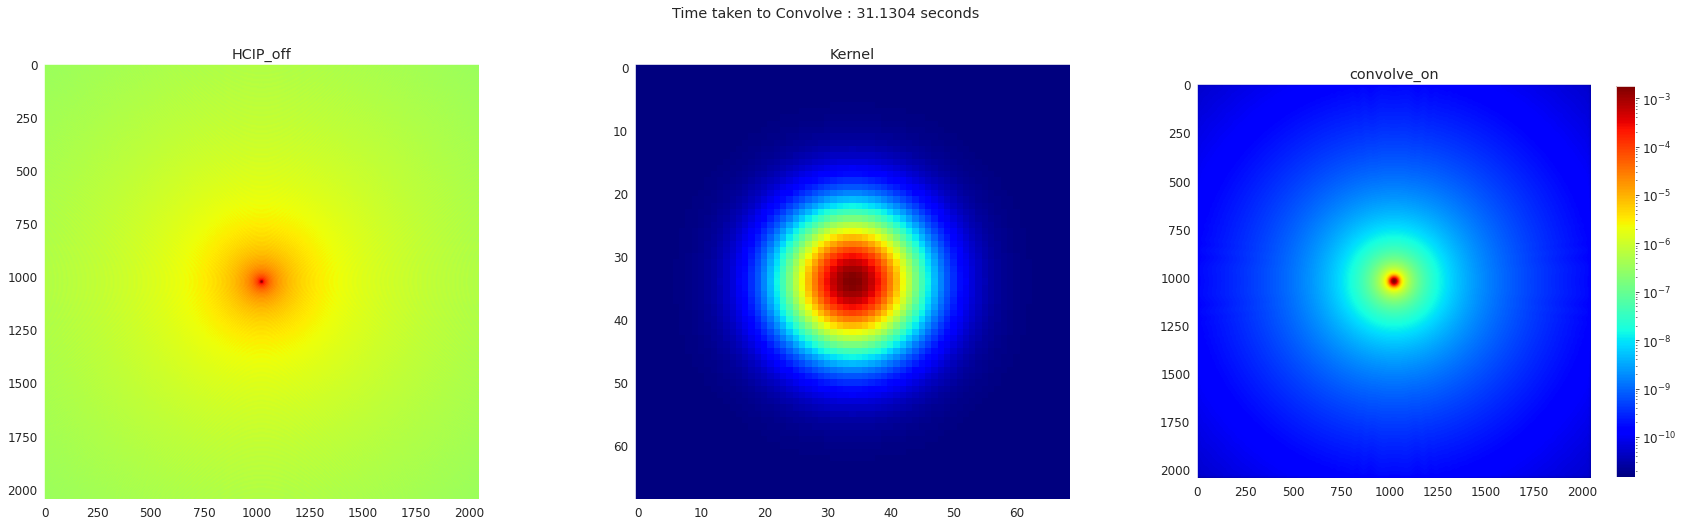

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("HCIP_off")
ax[0].imshow(off_axis, cmap="jet",norm=col.LogNorm())
start = perf_counter()
astropy_conv_off =  convolve(off_axis, kernel)

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_off, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


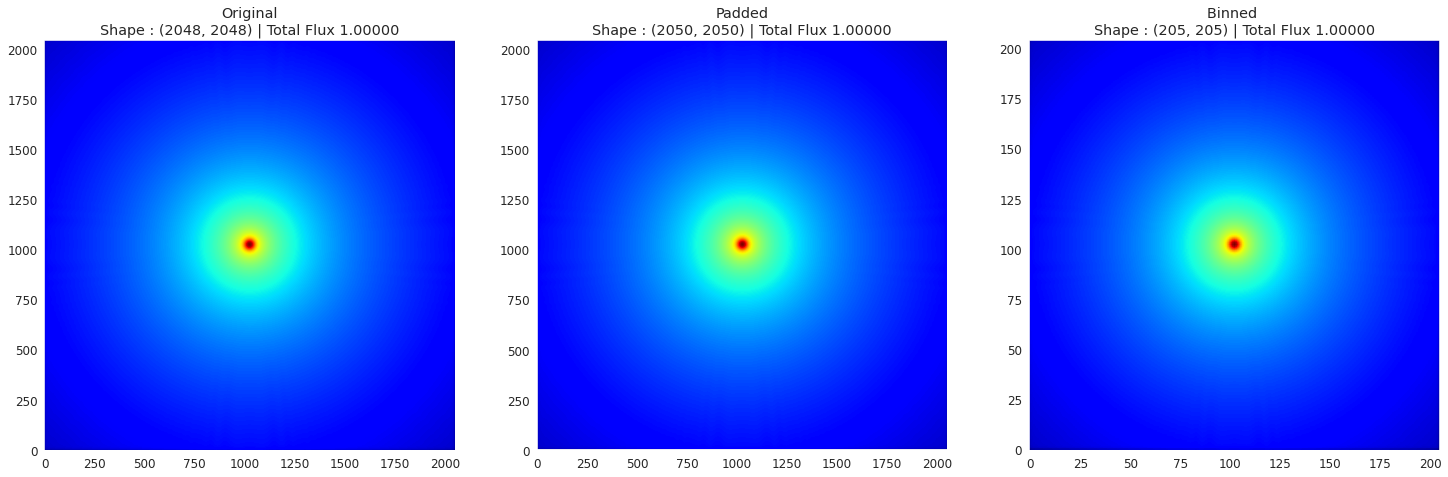

In [ ]:
Flux = astropy_conv_off    #Off_PSF
Flux_p = np.pad(Flux,((2,0),(0,2)),mode='constant')
Flux_b_off = Flux_p.reshape(205, 10, 205,10).sum(axis=(1,3))

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_off/Flux_b_off.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_off.shape,number=Flux_b_off.sum(), digits=5));

In [ ]:
def fwhm_pixel_dist(data,r_frac_min=0.0,r_frac_max=0.01):
  flux_p  = data.max()
  i_p,j_p = np.where(data == flux_p)

  coords = []
  for i in range(data.shape[0]):
    for j in range(data.shape[0]):
      f = data[i,j]
      if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
        break
    if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
      coords.append([i,j,f])
  coords = np.array(coords)

  dist = np.sqrt( (i_p[0]- coords[:,0])**2 + (j_p[0]- coords[:,1])**2 )*2
  return dist , dist.mean()

In [ ]:
fwhm_pixel_dist(Flux_b_off,r_frac_min=0.2)

(array([2.        , 2.82842712]), 2.414213562373095)

In [ ]:
np.save('off_axis_hcipy.npy',Flux_b_off)

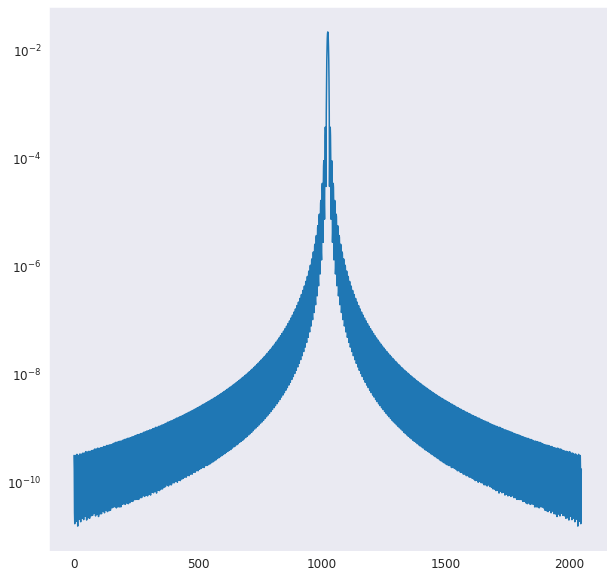

In [ ]:
plt.plot(off_axis[:,len(off_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(off_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'off_axis.fits',overwrite=True)

## **Circular Aperture with obstruction (INSIST-On Axis)**

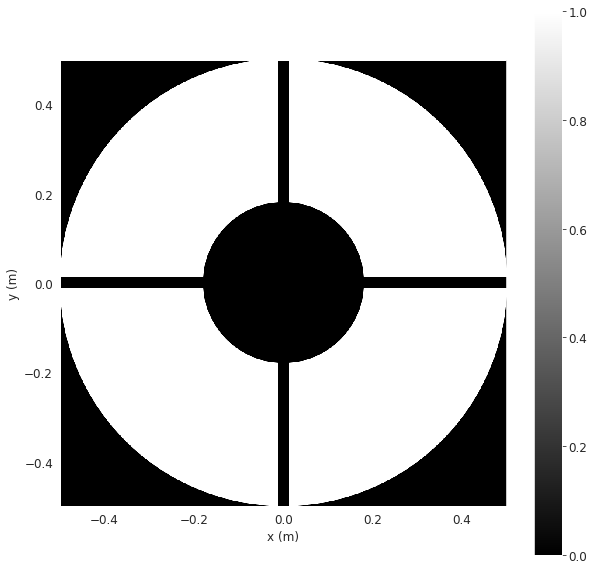

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(1024, diameter = pupil_diameter)

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36,num_spiders=4,spider_width= 0.025)

telescope_pupil_on_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_on_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_on_axis,wavelength)
  focal_grid = make_focal_grid(q=6, num_airy=4*42.68,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

(2048, 2048)

In [ ]:
on_axis = np.array(focal_total/10)
on_axis = on_axis/on_axis.sum()
on_axis.sum()

1.0

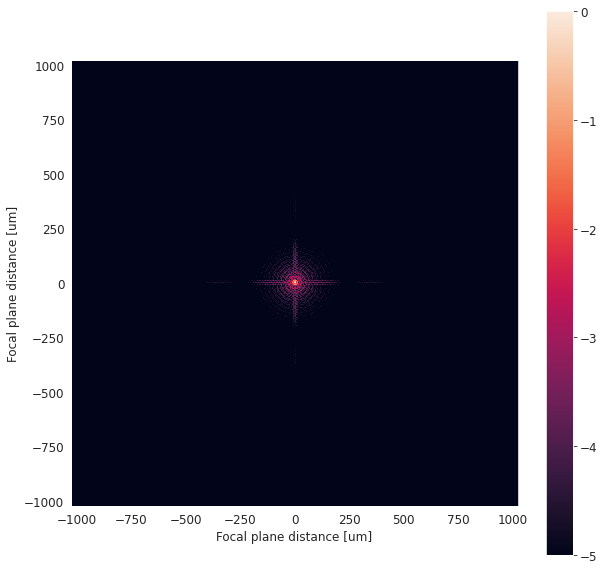

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

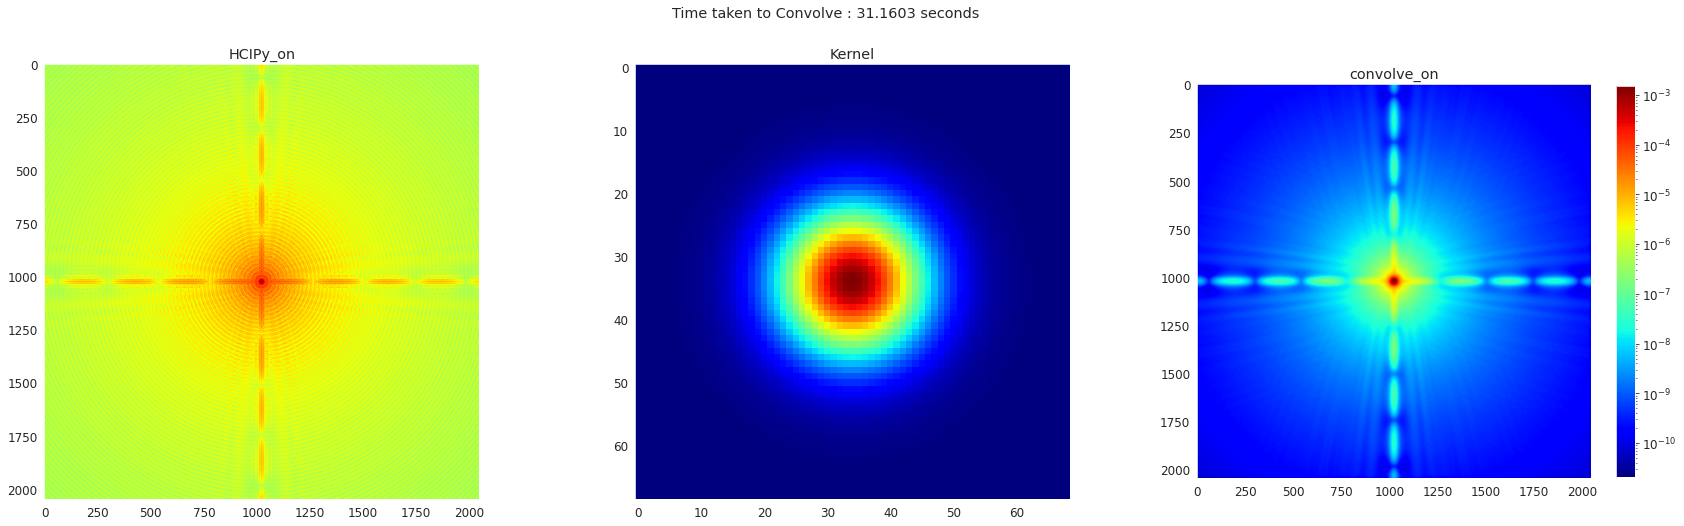

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("HCIPy_on")
ax[0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()
start = perf_counter()
astropy_conv_on = convolve(on_axis, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


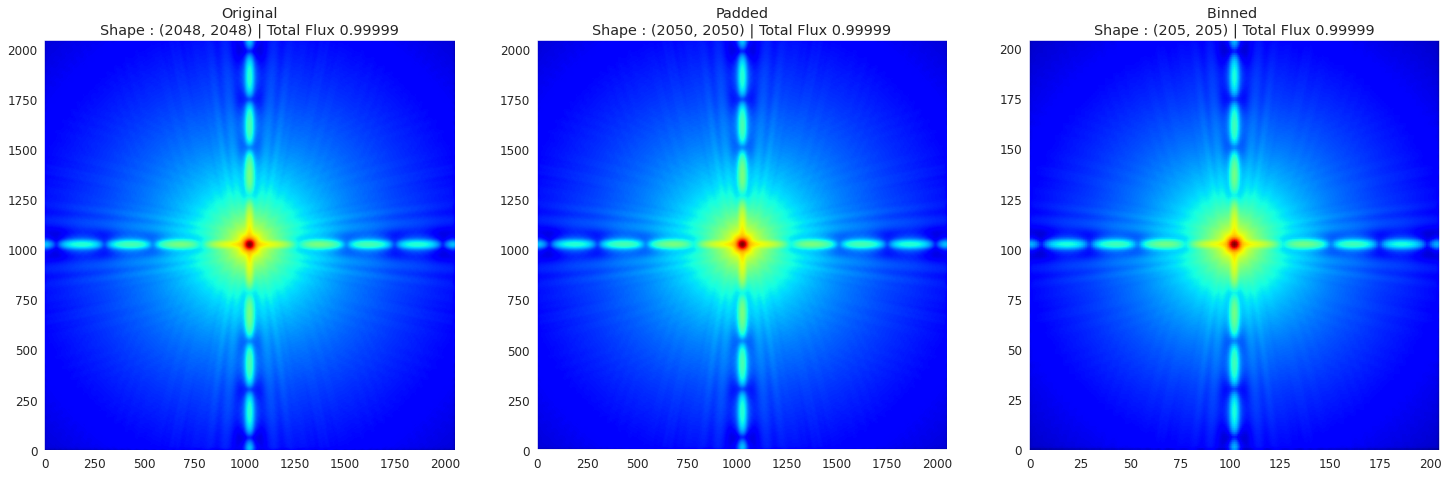

In [ ]:
Flux = astropy_conv_on
Flux_p = np.pad(Flux,((2,0), (0,2)),mode='constant')
Flux_b_on = Flux_p.reshape(205,10, 205,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_on/Flux_b_on.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_on.shape,number=Flux_b_on.sum(), digits=5));

In [ ]:
np.save('on_axis_hcipy.npy',Flux_b_on)

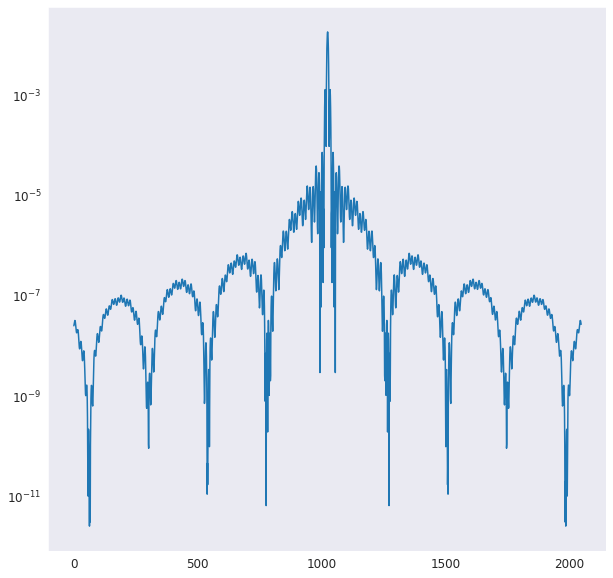

In [ ]:
plt.plot(on_axis[:,len(on_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(on_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'on_axis.fits',overwrite=True)

## **Circular Aperture with tangential Spider (UVIT-On Axis)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  


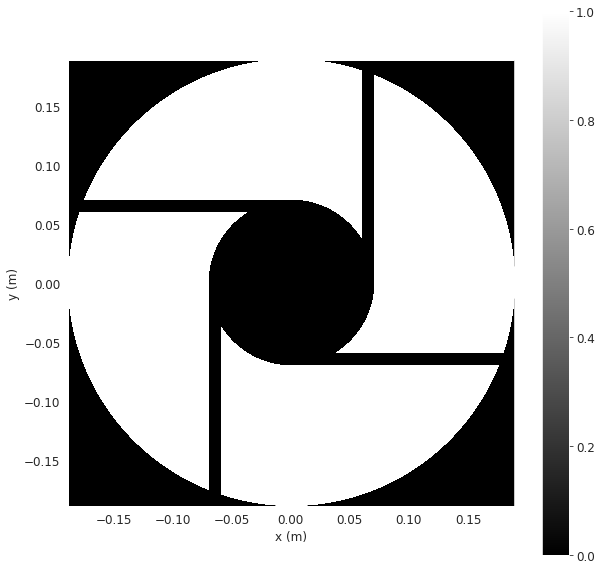

In [ ]:
pupil_diameter = 37.8/100 # m

effective_focal_length = 437/100 # m

pupil_grid = make_pupil_grid(5000, diameter = pupil_diameter)

pupil_outer = circular_aperture(pupil_diameter)(pupil_grid)
pupil_inner = circular_aperture(14/100)(pupil_grid)

pupil_ring = pupil_outer - pupil_inner

aperture = make_obstructed_circular_aperture(pupil_diameter,14/37.8)

telescope_pupil_off_axis_v2 = evaluate_supersampled(aperture , pupil_grid  ,8)

spiders1= make_spider((0, -0.065), (0.189, -0.065), 0.01)(pupil_grid)
spiders2= make_spider((0.065, 0), (0.065, 0.189), 0.01)(pupil_grid)
spiders3= make_spider((0, 0.065), (-0.189, 0.065), 0.01)(pupil_grid)
spiders4= make_spider((-0.065, 0), (-0.065, -0.189), 0.01)(pupil_grid)

for spider in [spiders1,spiders2,spiders3,spiders4]:
  telescope_pupil_off_axis_v2*=spider*pupil_ring


im = imshow_field(telescope_pupil_off_axis_v2, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  wavefront = Wavefront(telescope_pupil_off_axis_v2,wavelength)
  focal_grid = make_focal_grid(q=11.09, num_airy=92.44,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
2050/(11.09*2)

92.42560865644725

In [ ]:
focal_total.shape

(2050, 2050)

In [ ]:
(focal_grid.separated_coords[0].max() - focal_grid.separated_coords[0].min())/(focal_total.shape[0]*1e-6)

0.3125845028899859

In [ ]:
on_axis_v2 = focal_total/focal_total.sum()

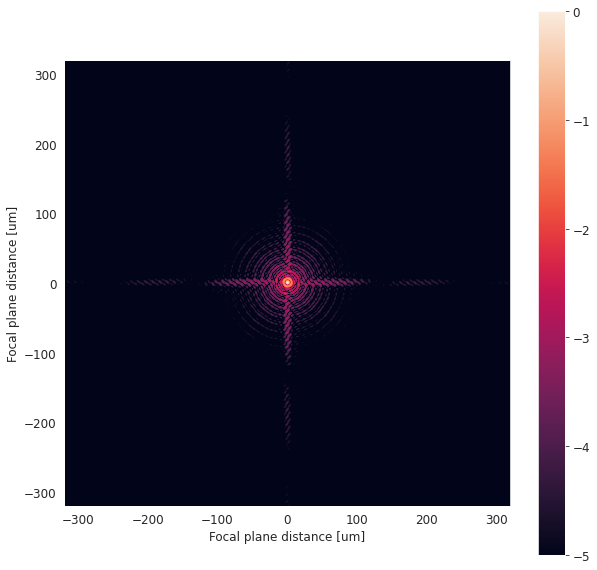

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

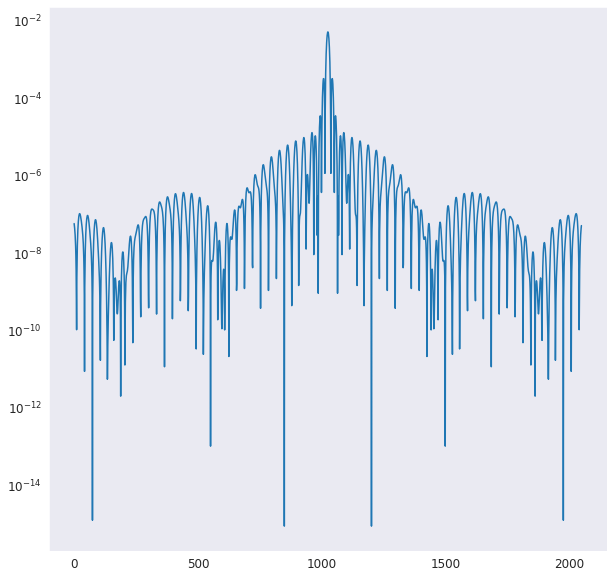

In [ ]:
plt.plot(on_axis_v2[:,len(on_axis_v2)//2])
plt.yscale('log')

In [ ]:
3.33/8

0.41625

In [ ]:
fwhm_in     = 1.4  # arcsecs
pixel_scale = 0.041625  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

14.282889133972692

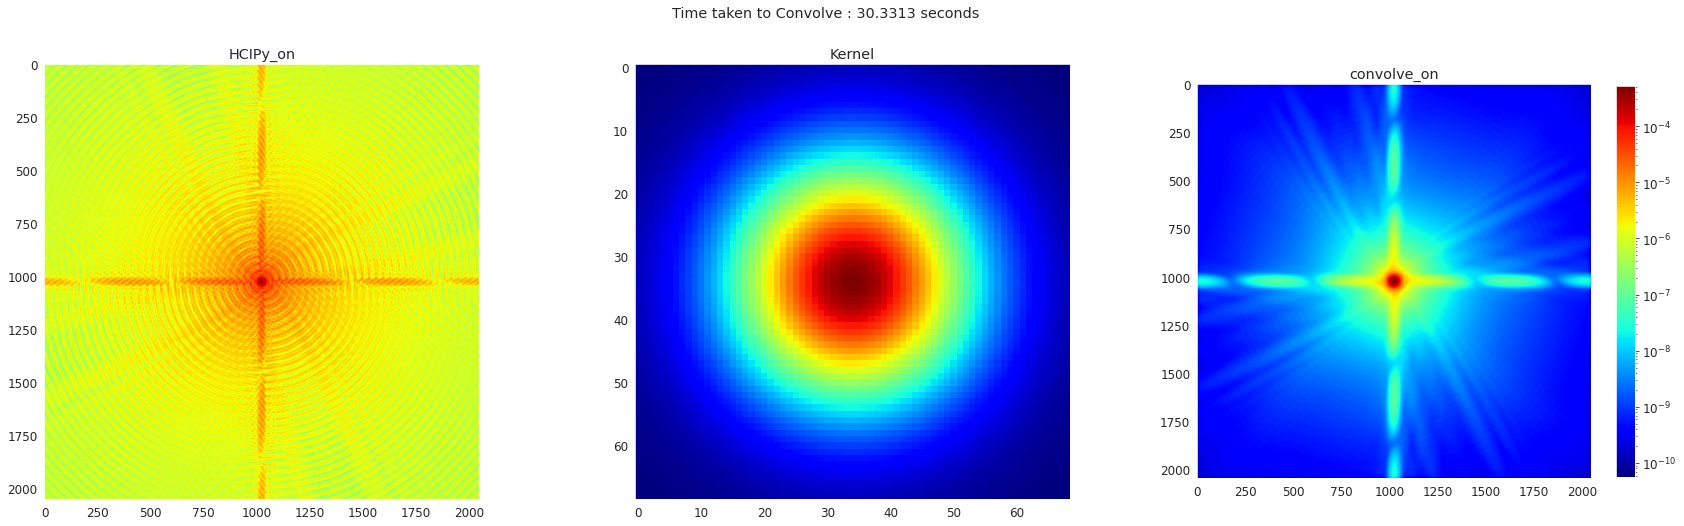

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("HCIPy_on")
ax[0].imshow(on_axis_v2, cmap="jet",norm=col.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()
start = perf_counter()
astropy_conv_on = convolve(on_axis_v2, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

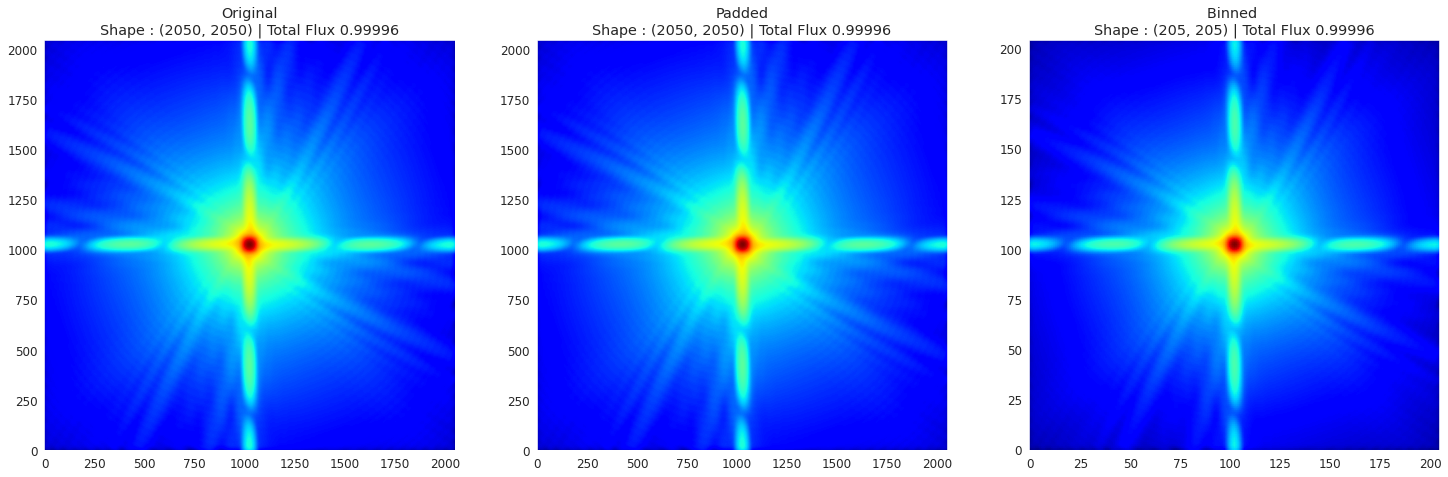

In [ ]:
Flux = astropy_conv_on
Flux_p = Flux
Flux_b_on = Flux_p.reshape(205,10, 205,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_on/Flux_b_on.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_on.shape,number=Flux_b_on.sum(), digits=5));

In [ ]:
np.save('on_axis_hcipy.npy',Flux_b_on)

In [ ]:
ls

INSIST/  on_axis_hcipy.npy  sample_data/


# **PSF Simulation using POPPY**

In [11]:
import poppy as poy
import astropy.units as u

## **On Axis**

In [ ]:
osys = poy.OpticalSystem(oversample = 10, npix = 4000)

# On axis Aperture
osys.add_pupil(poy.CircularAperture(radius=1*u.meter))
osys.add_pupil(poy.SecondaryObscuration(secondary_radius = 18*u.cm,
                                        support_width = 2.5*u.cm,
               support_angle_offset = 0))

# MOS
ap1 = poy.SquareAperture(size = 1*u.m)
ap2 = poy.SecondaryObscuration(secondary_radius = 1*u.cm,
                                        support_width = 2.5*u.cm,
               support_angle_offset = 0)

atlast = poy.CompoundAnalyticOptic( opticslist=[ap1, ap2 ], name='MOS Mirrorlets')
#osys.add_pupil(atlast)


# Detector
osys.add_detector(pixelscale=0.1, fov_arcsec=40.1)

psfs = 0
for wav in np.linspace(150,300,100):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

In [ ]:
psf[0].data = psfs/psfs.max()

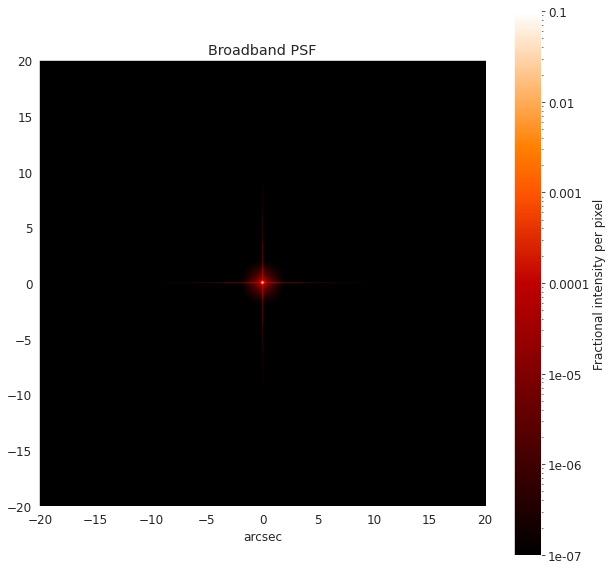

In [ ]:
poy.display_psf(psf, title = 'Broadband PSF')
plt.grid(False)

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

on_axis = psfs/psfs.max()
kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

conv_on =  fftconvolve(on_axis, kernel, mode = 'same')
conv_on_binned = conv_on.reshape(401, 10, 401,10).sum(axis=(1,3))

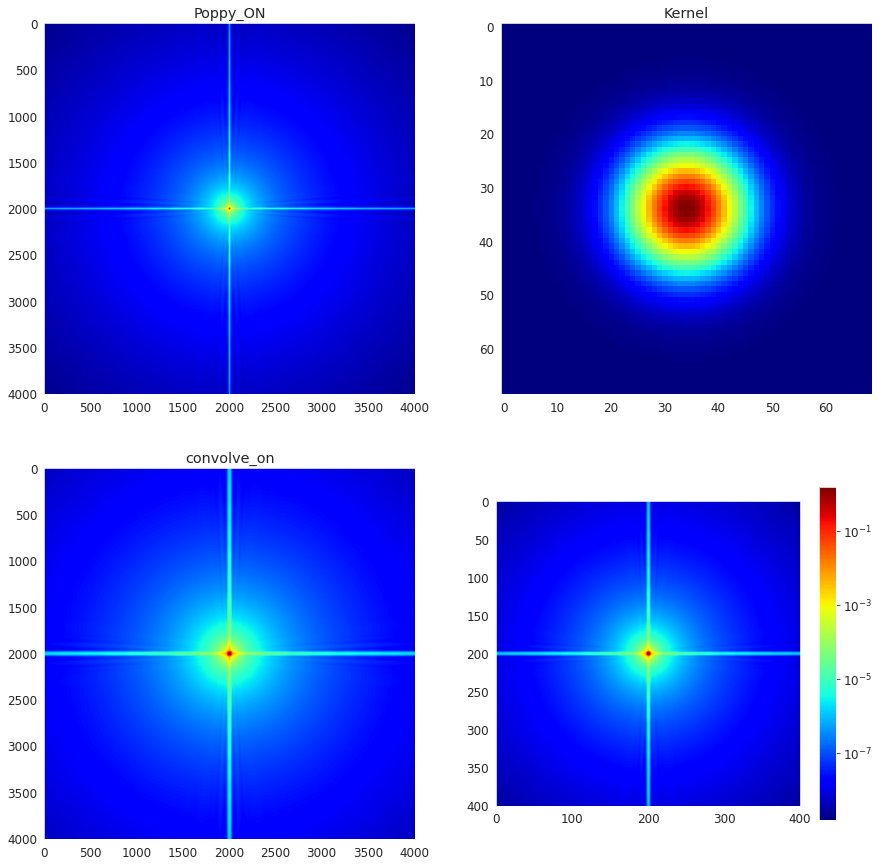

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_on, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_on_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

In [ ]:
np.save('on_axis_poppy.npy', conv_on_binned/conv_on_binned.max())

## **Off Axis**

In [ ]:
osys = poy.OpticalSystem(oversample = 10, npix = 4000)

# On axis Aperture
osys.add_pupil(poy.CircularAperture(radius=1*u.meter))

# Detector
osys.add_detector(pixelscale=0.1, fov_arcsec=40.1)

psfs = 0
for wav in np.linspace(150,300,100):
  psf = osys.calc_psf(wav*1e-9)
  psfs += psf[0].data

In [ ]:
psf[0].data = psfs/psfs.max()

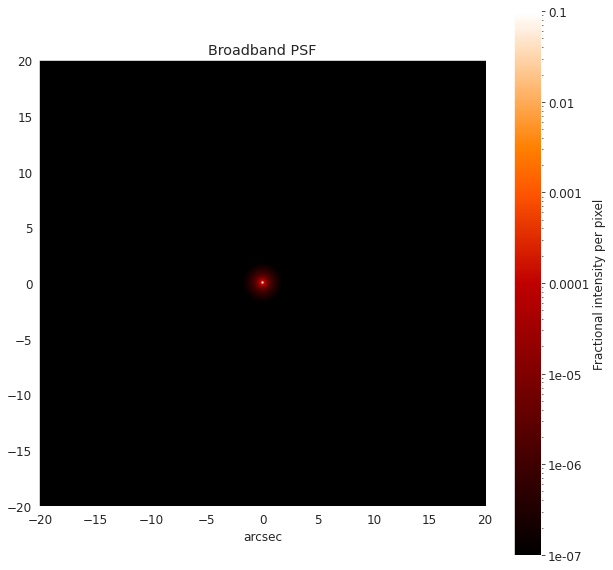

In [ ]:
poy.display_psf(psf, title = 'Broadband PSF')
plt.grid(False)

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

off_axis = psfs/psfs.max()
kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

conv_off =  fftconvolve(off_axis, kernel, mode = 'same')
conv_off_binned = conv_off.reshape(401, 10, 401,10).sum(axis=(1,3))

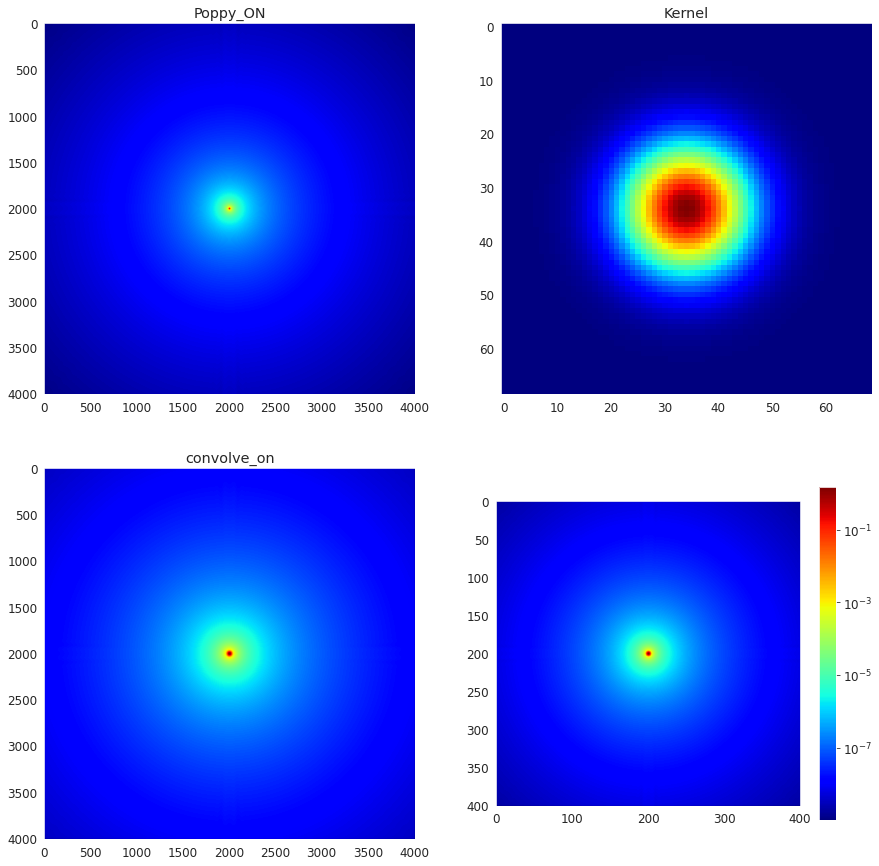

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].set_title("Poppy_ON")

ax[0,0].imshow(off_axis, cmap="jet",norm=col.LogNorm())

ax[0,1].set_title("Kernel")
ax[0,1].imshow(kernel, cmap="jet")

ax[1,0].set_title("convolve_on")
im_on = ax[1,0].imshow(conv_off, cmap="jet",norm=col.LogNorm())

im_on = ax[1,1].imshow(conv_off_binned, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)

In [ ]:
np.save('off_axis_poppy.npy', conv_off_binned/conv_off_binned.max())

## **TMT**


In [24]:
pri = poy.HexSegmentedDeformableMirror(rings=10, flattoflat=1.44, gap=2.5e-3, center= False)
sec = poy.SecondaryObscuration(secondary_radius=3.1, n_supports=6, support_width=0.1)
atlast = poy.CompoundAnalyticOptic( opticslist=[pri, sec], name='Mock ATLAST')

In [ ]:
poy.removePadding

<Axes: title={'center': 'Transmittance for Mock ATLAST'}, ylabel='[meters]'>

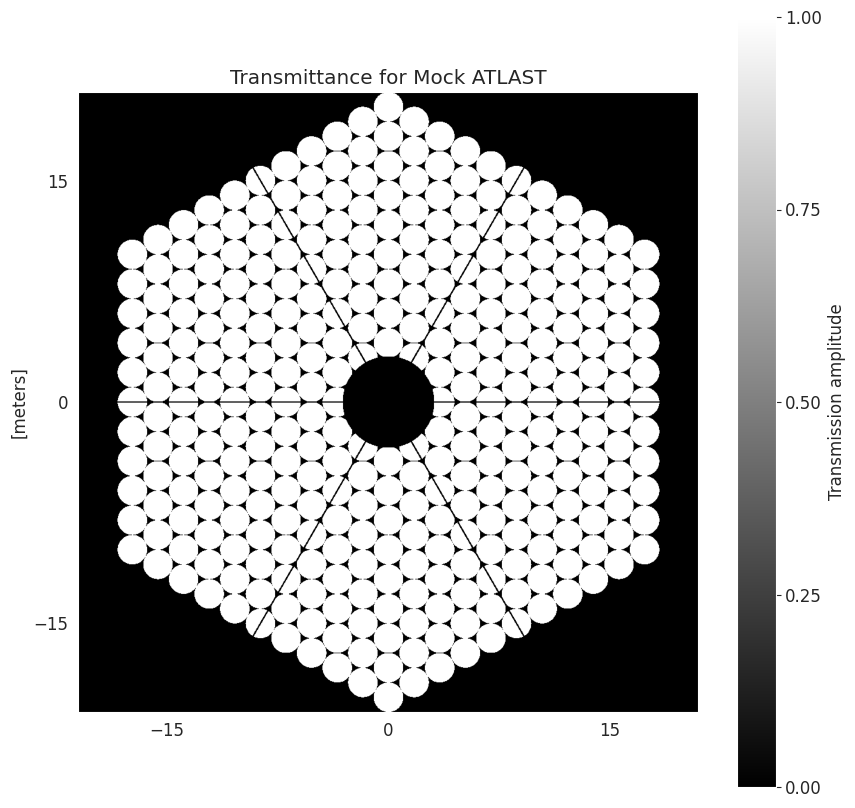

In [25]:
atlast.display(npix=1024, colorbar_orientation='vertical')

# **Detector Simulator using pyxel**

Work in progress

In [ ]:
!pyxel download-examples

Done.


In [ ]:
psf.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

In [ ]:
hdu = fits.open('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

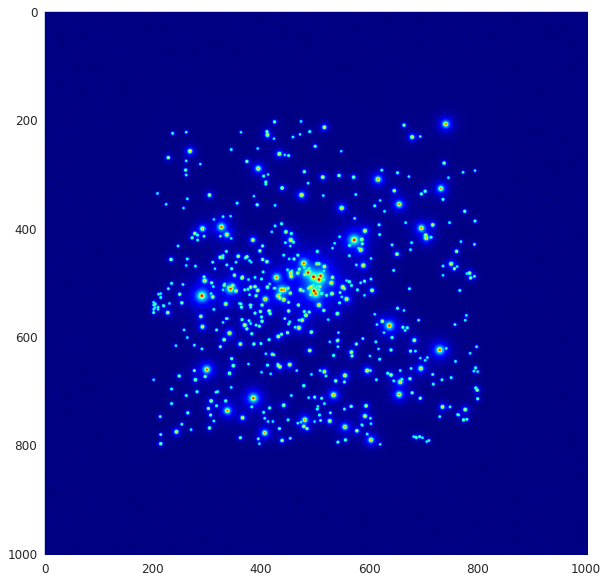

In [ ]:
data= hdu[0].data
plt.imshow(data, cmap = 'jet', norm = col.LogNorm())

In [ ]:
hdu_n = fits.PrimaryHDU(data,header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_m.fits',overwrite = True)

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml",'r') as f:
  dat = yaml.load(f)

In [ ]:
dat

In [ ]:
dat['pipeline']['photon_generation'][0]['arguments']['image_file'] = 'data/source_m.fits'

In [ ]:
dat['pipeline']['optics'][0]['arguments']['fov_arcsec'] = 20.5

In [ ]:
dat['cmos_detector']['geometry']['row']= data.shape[0]
dat['cmos_detector']['geometry']['col']= data.shape[1]
dat['cmos_detector']['geometry']['total_thickness'] = 1 #dat['ccd_detector']['geometry']['pixel_vert_size']*dat['ccd_detector']['geometry']['row']

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml", 'w') as out:
  yaml.dump(dat,out)

In [ ]:
config = pyxel.load("/content/INSIST/data/exposure_on.yaml")
exposure = config.exposure  # class Single
detector = config.cmos_detector  # class CCD
pipeline = config.pipeline  # class DetectionPipeline

In [ ]:
detector

In [ ]:
cd /content/INSIST/data/pyxel-examples/tutorial

/content/INSIST/data/pyxel-examples/tutorial


In [ ]:
result = pyxel.exposure_mode(exposure=exposure, detector=detector, pipeline=pipeline)
result

TypeError: ignored

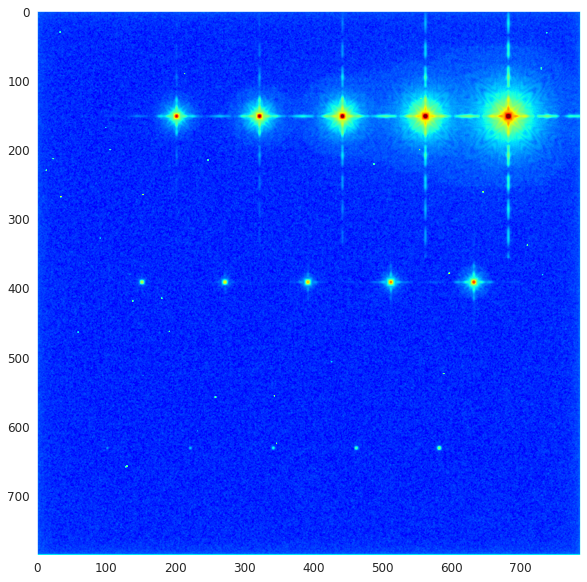

In [ ]:
plt.imshow(result.pixel.data[0], cmap = 'jet', norm = col.LogNorm());

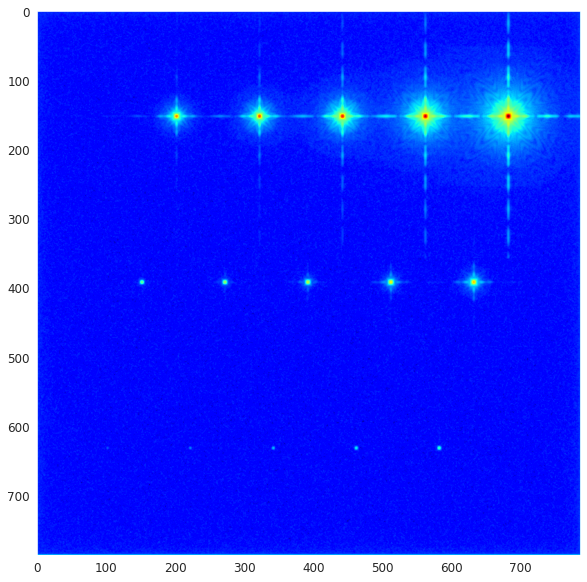

In [ ]:
plt.imshow(detector.photon.array, cmap = 'jet', norm = col.LogNorm());

In [ ]:
detector.__dict__

{'_characteristics': <pyxel.detectors.ccd_characteristics.CCDCharacteristics at 0x7fa570373b50>,
 '_charge': <pyxel.data_structure.charge.Charge at 0x7fa570388f90>,
 '_geometry': CCDGeometry(row=787, col=787, total_thickness=7870.0, pixel_vert_size=10.0, pixel_horz_size=10.0),
 '_image': Image<shape=(787, 787), dtype=uint32>,
 '_memory': {},
 '_numbytes': 3768,
 '_output_dir': PosixPath('/content/INSIST/data/pyxel-examples/tutorial/output/run_20220324_060126'),
 '_persistence': None,
 '_photon': Photon<shape=(787, 787), dtype=float64>,
 '_pixel': Pixel<shape=(787, 787), dtype=float64>,
 '_readout_properties': <pyxel.detectors.readout_properties.ReadoutProperties at 0x7fa570377590>,
 '_signal': Signal<shape=(787, 787), dtype=float64>,
 'environment': Environment(temperature=300),
 'header': OrderedDict(),
 'input_image': array([[3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        ...,
        [3., 3., 3., ..., 3., 3., 3.],


In [ ]:
detector.input_image.min()

3.0

In [ ]:
hdu_n = fits.PrimaryHDU(result.pixel.data[0],header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/output.fits',overwrite = True)

In [ ]:
hdul[0].data.shape

(787, 787)